In [635]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

from sklearn import metrics
from sklearn.metrics import auc, roc_curve, classification_report
from sklearn.metrics import r2_score


## Load Dataset

In [636]:
#Load Dataset
data=pd.read_csv('Business Case.csv',parse_dates=['d_observation_date','d_acq_date','d_last_payment_date','d_last_sms_date','d_rpc_date','d_lawsuit_date','d_payment_order_date','d_title_day','d_execution_date','d_unsuccesfull_exe_date','d_maturity_date','d_inactivation_date','d_last_broken_date','d_last_inbound_date'],dayfirst=True)
data.head()

,c_accountid,d_observation_date,c_entity,n_account_balance,d_acq_date,n_active_num,n_tel_notel,d_last_payment_date,n_pay_30,n_pay_60,...,n_in_dialler_obs_day,n_arrangement_active,d_inactivation_date,d_last_broken_date,c_subregion,gender,age,d_last_inbound_date,Target_Amount,Target
0,4169220,2022-01-01,Entity 1,4643.12,2018-04-13,2,1,NaT,0.0,0.0,...,1,0,NaT,NaT,Subregion_59,M,31,NaT,3500.0,1
1,4169508,2022-01-01,Entity 1,4823.09,2018-04-13,4,1,NaT,0.0,0.0,...,1,0,NaT,NaT,Subregion_28,M,28,NaT,0.0,0
2,4169571,2022-01-01,Entity 1,966.41,2018-04-13,1,1,NaT,0.0,0.0,...,1,0,NaT,NaT,NaN,M,35,NaT,0.0,0
3,4180740,2022-01-01,Entity 1,496.58,2018-04-13,1,1,NaT,0.0,0.0,...,1,0,NaT,NaT,Subregion_5,M,31,NaT,0.0,0
4,4167348,2022-01-01,Entity 1,2609.66,2018-04-13,1,1,NaT,0.0,0.0,...,1,0,NaT,NaT,Subregion_25,M,30,NaT,0.0,0


In [462]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3470 entries, 0 to 3469
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   c_accountid                      3470 non-null   int64         
 1   d_observation_date               3470 non-null   datetime64[ns]
 2   c_entity                         3470 non-null   object        
 3   n_account_balance                3470 non-null   float64       
 4   d_acq_date                       3470 non-null   datetime64[ns]
 5   n_active_num                     3470 non-null   int64         
 6   n_tel_notel                      3470 non-null   int64         
 7   d_last_payment_date              313 non-null    datetime64[ns]
 8   n_pay_30                         3470 non-null   float64       
 9   n_pay_60                         3470 non-null   float64       
 10  n_pay_90                         3470 non-null   float64    

In [554]:
# check missing values
missing=data.isnull().sum()/3470
missing[missing>0].sort_values(ascending=False)

d_last_inbound_date        0.968300
d_rpc_date                 0.935735
d_last_payment_date        0.909798
d_inactivation_date        0.894813
d_last_broken_date         0.845245
d_last_sms_date            0.617867
d_unsuccesfull_exe_date    0.529683
c_subregion                0.350720
d_payment_order_date       0.281556
d_execution_date           0.273775
d_title_day                0.236599
d_lawsuit_date             0.208069
d_maturity_date            0.046686
dtype: float64

## Visualization and Feature Engineering

our main goal is to predict whether or not the user is going to repay the loan.

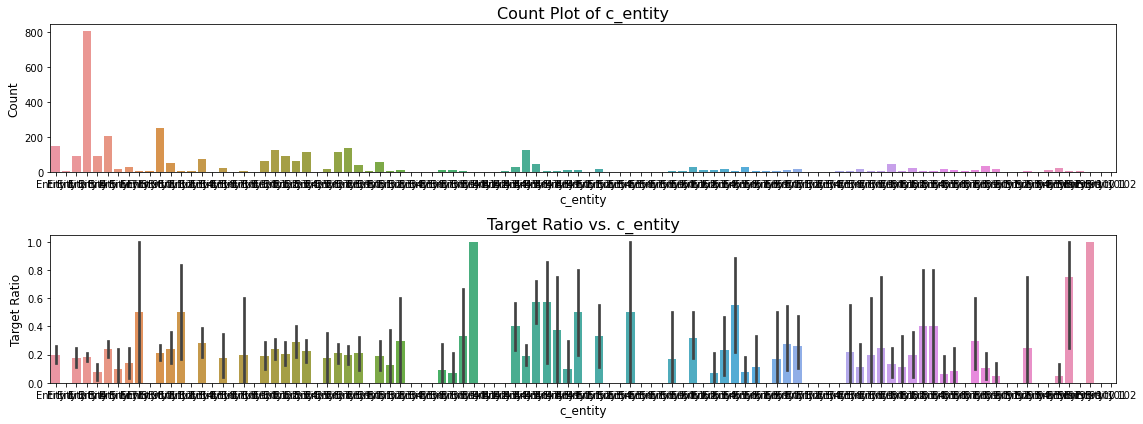

In [465]:
#visualization of 'c_entity'
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 6))
sns.countplot(x='c_entity', data=data, ax=ax[0])
ax[0].set_xlabel('c_entity', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of c_entity', fontsize=16)

sns.barplot(x='c_entity', y='Target', data=data, ax=ax[1])
ax[1].set_xlabel('c_entity', fontsize=12)
ax[1].set_ylabel('Target Ratio', fontsize=12)
ax[1].set_title('Target Ratio vs. c_entity', fontsize=16)
plt.tight_layout()
plt.show()

In [637]:
#Feature engineering: create new feature 'vendor' with 3 category
vendor_mean=data[['c_entity','Target']].groupby('c_entity').mean().sort_values(by='Target',ascending=False).reset_index()

vendor_1=list(vendor_mean[vendor_mean['Target']>0.3]['c_entity'])
vendor_3=list(vendor_mean[vendor_mean['Target']<0.2]['c_entity'])

def new_vendor(entity):
    if entity in vendor_1: return 1
    if entity in vendor_3: return 3
    else:
        return 2
data['vendor']=data['c_entity'].apply(new_vendor)

data['vendor'].value_counts()

3    1864
2    1415
1     191
Name: vendor, dtype: int64

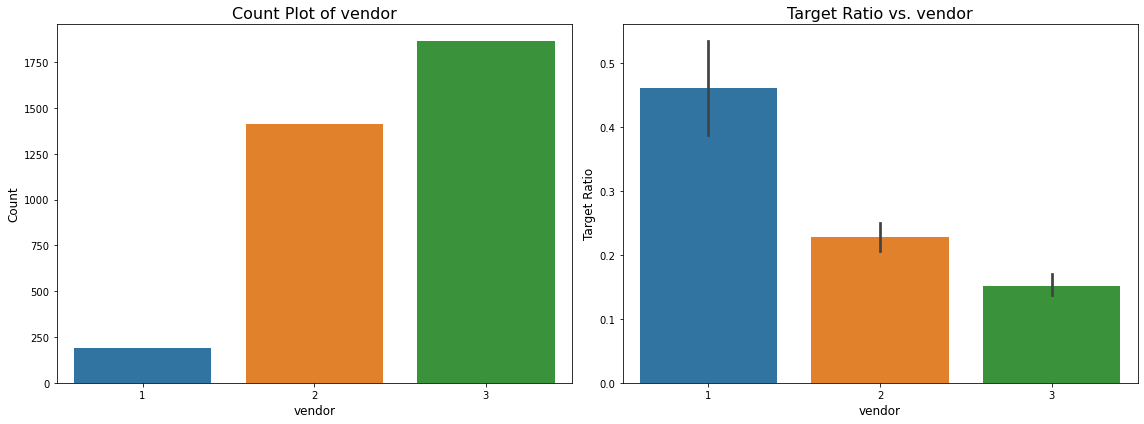

In [411]:
#visualization new feature of 'vendor'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='vendor', data=data, ax=ax[0])
ax[0].set_xlabel('vendor', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of vendor', fontsize=16)

sns.barplot(x='vendor', y='Target', data=data, ax=ax[1])
ax[1].set_xlabel('vendor', fontsize=12)
ax[1].set_ylabel('Target Ratio', fontsize=12)
ax[1].set_title('Target Ratio vs. vendor', fontsize=16)
plt.tight_layout()
plt.show()

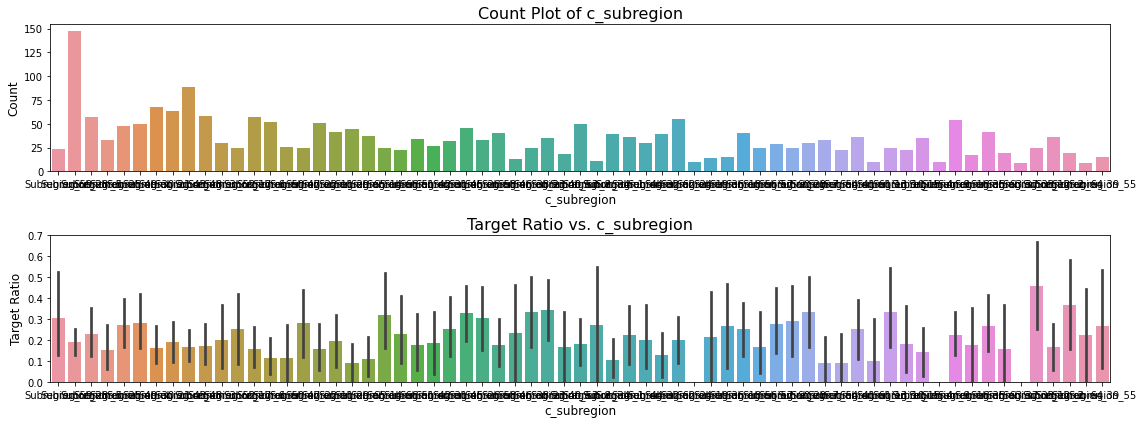

In [405]:
# visualization of 'c_subregion'
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 6))
sns.countplot(x='c_subregion', data=data, ax=ax[0])
ax[0].set_xlabel('c_subregion', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of c_subregion', fontsize=16)

sns.barplot(x='c_subregion', y='Target', data=data, ax=ax[1])
ax[1].set_xlabel('c_subregion', fontsize=12)
ax[1].set_ylabel('Target Ratio', fontsize=12)
ax[1].set_title('Target Ratio vs. c_subregion', fontsize=16)
plt.tight_layout()
plt.show()

In [638]:
#Feature engineering: create new feature of 'sub_region'
subregion_mean=data[['c_subregion','Target']].groupby('c_subregion').mean().sort_values(by='Target',ascending=False).reset_index()

subregion_1=list(subregion_mean[subregion_mean['Target']>0.3]['c_subregion'])
subregion_3=list(subregion_mean[subregion_mean['Target']<0.2]['c_subregion'])

def new_region(entity):
    if entity in subregion_1: return 1
    if entity in subregion_3: return 3
    else:
        return 2
data['sub_region']=data['c_subregion'].apply(new_region)

data['sub_region'].value_counts()

2    1927
3    1260
1     283
Name: sub_region, dtype: int64

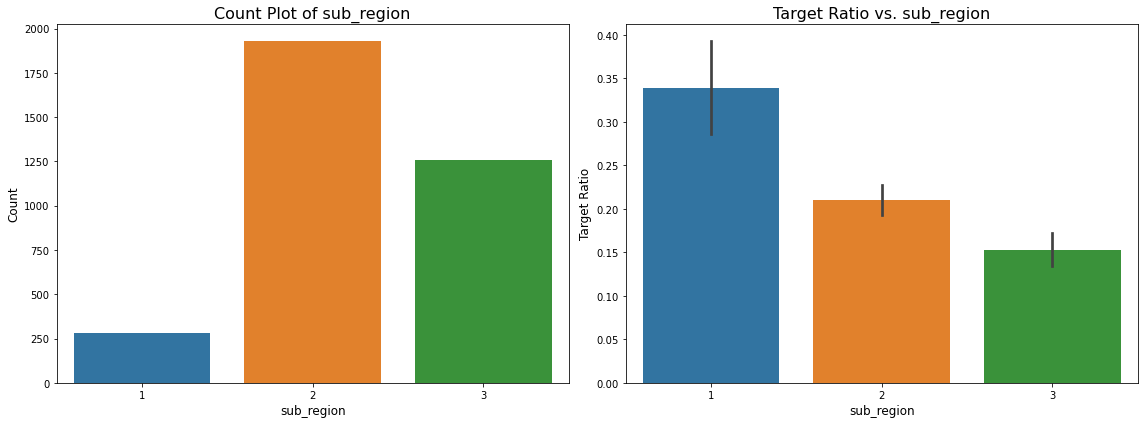

In [417]:
#visulisation new feature sub_region
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='sub_region', data=data, ax=ax[0])
ax[0].set_xlabel('sub_region', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of sub_region', fontsize=16)

sns.barplot(x='sub_region', y='Target', data=data, ax=ax[1])
ax[1].set_xlabel('sub_region', fontsize=12)
ax[1].set_ylabel('Target Ratio', fontsize=12)
ax[1].set_title('Target Ratio vs. sub_region', fontsize=16)
plt.tight_layout()
plt.show()

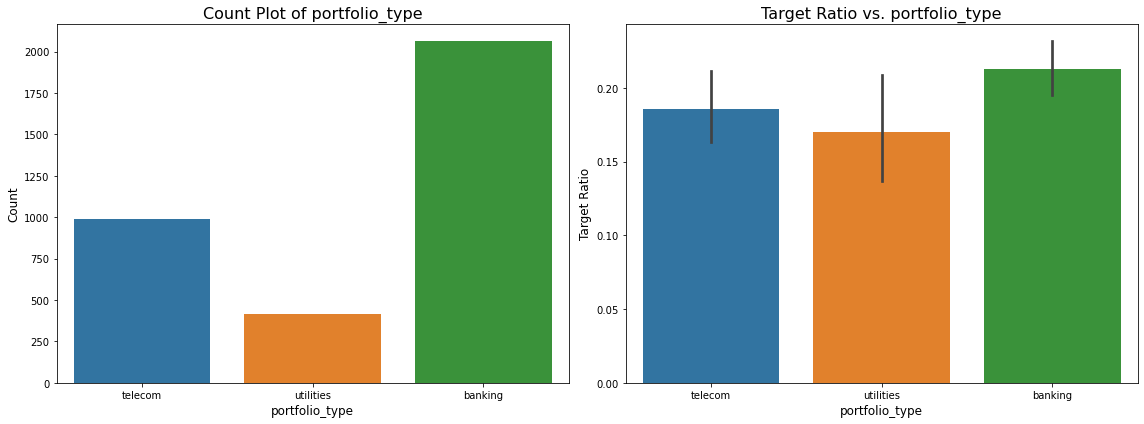

In [418]:
#visualization of 'portforlio type'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='c_type_of_portfolio_rap', data=data, ax=ax[0])
ax[0].set_xlabel('portfolio_type', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of portfolio_type', fontsize=16)

sns.barplot(x='c_type_of_portfolio_rap', y='Target', data=data, ax=ax[1])
ax[1].set_xlabel('portfolio_type', fontsize=12)
ax[1].set_ylabel('Target Ratio', fontsize=12)
ax[1].set_title('Target Ratio vs. portfolio_type', fontsize=16)
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='n_deceased', ylabel='Target'>

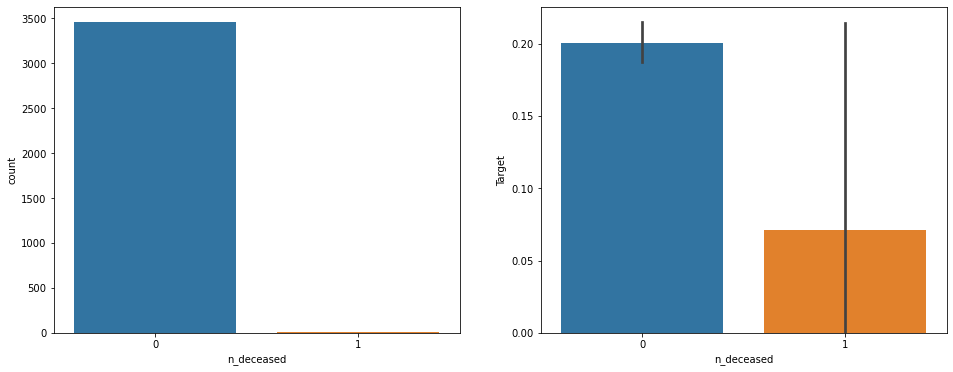

In [342]:
#visualization of 'n_deceased'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='n_deceased', data=data, ax=ax[0])
sns.barplot(x='n_deceased', y='Target', data=data, ax=ax[1])

<AxesSubplot:xlabel='n_bancrupcy_failed_lawsuits_etc', ylabel='Target'>

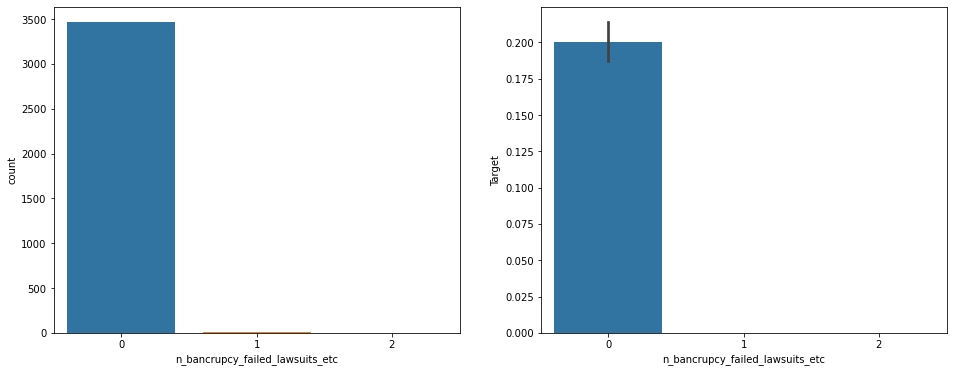

In [343]:
#visualization of 'ancrupcy_failed'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='n_bancrupcy_failed_lawsuits_etc', data=data, ax=ax[0])
sns.barplot(x='n_bancrupcy_failed_lawsuits_etc', y='Target', data=data, ax=ax[1])

In [639]:
# Feature Engineering
# Get age for each client by calculating difference between d_observation_date and d_acq_date
age_PRA=data['d_observation_date']-data['d_acq_date']
age_PRA=age_PRA.apply(lambda x: x.days/30)
data['age_PRA_mt']=age_PRA

# get the month since last contact
time_contact=data['d_observation_date']-data['d_rpc_date']
time_contact=time_contact.apply(lambda x: x.days/30)
data['time_contact']=time_contact

#get the month since last sms
time_sms=data['d_observation_date']-data['d_last_sms_date']
time_sms=time_sms.apply(lambda x: x.days/30)
data['time_sms']=time_sms

#get the month since last inbound call
time_inbound=data['d_observation_date']-data['d_last_inbound_date']
time_inbound=time_inbound.apply(lambda x: x.days/30)
data['time_inbound']=time_inbound

#Get the time difference between last payment time and last contact time, positive means there is payment after contact
time_diff_1=data['d_last_payment_date']-data['d_rpc_date']
time_diff_1=time_diff_1.apply(lambda x: 1 if x.days>0 else 0)
data['contact_works']=time_diff_1

#Get the time difference between last payment time and last SMS time, positive means there is payment after SMS
time_diff_2=data['d_last_payment_date']-data['d_last_sms_date']
time_diff_2=time_diff_2.apply(lambda x: 1 if x.days>0 else 0)
data['sms_works']=time_diff_2

#Get the time difference between last payment time and last inbound call time, positive means there is payment after inbound calls
time_diff_3=data['d_last_payment_date']-data['d_last_inbound_date']
time_diff_3=time_diff_3.apply(lambda x: 1 if x.days>0 else 0)
data['inbound_works']=time_diff_3




<AxesSubplot:xlabel='contact_works', ylabel='Target'>

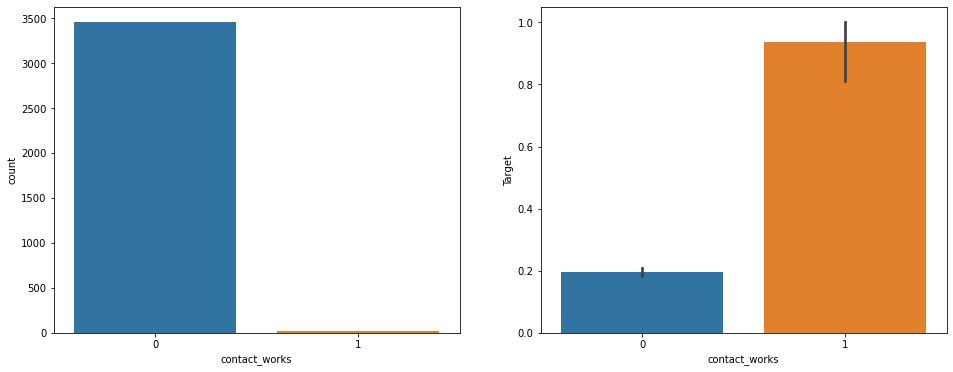

In [79]:
# visualisation
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='contact_works', data=data, ax=ax[0])
sns.barplot(x='contact_works',y='Target',data=data,ax=ax[1])

<AxesSubplot:xlabel='sms_works', ylabel='Target'>

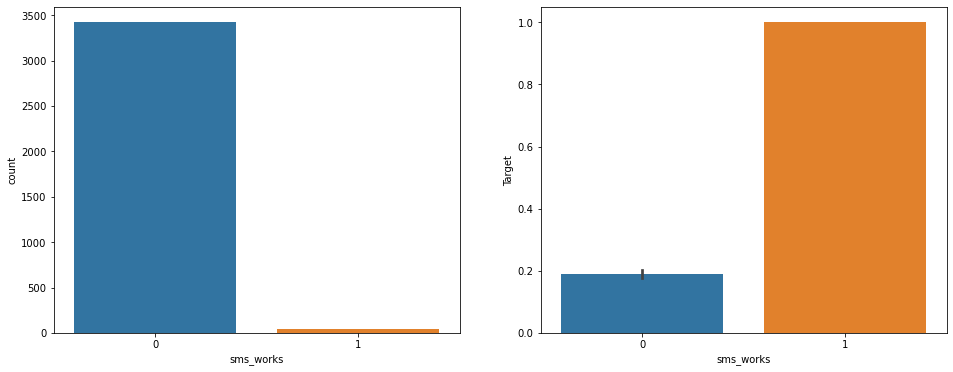

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='sms_works', data=data, ax=ax[0])
sns.barplot(x='sms_works',y='Target',data=data,ax=ax[1])

<AxesSubplot:xlabel='inbound_works', ylabel='Target'>

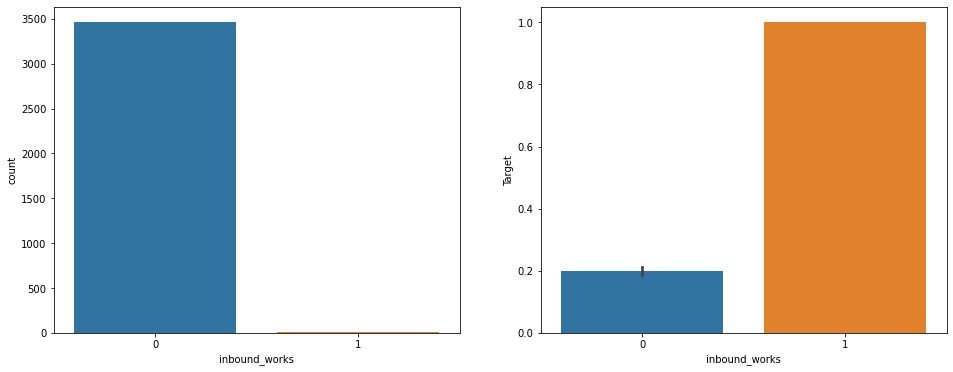

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='inbound_works', data=data, ax=ax[0])
sns.barplot(x='inbound_works',y='Target',data=data,ax=ax[1])

<AxesSubplot:xlabel='gender', ylabel='Target'>

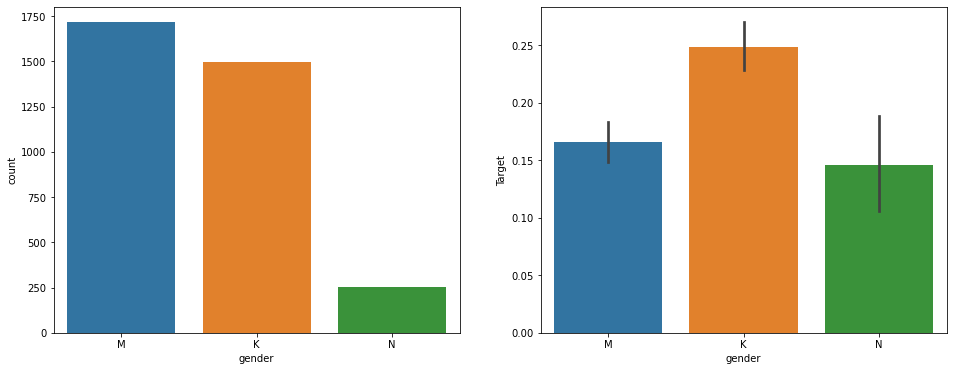

In [419]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='gender', data=data, ax=ax[0])
sns.barplot(x='gender',y='Target',data=data,ax=ax[1])

<AxesSubplot:xlabel='n_arrangement_active', ylabel='Target'>

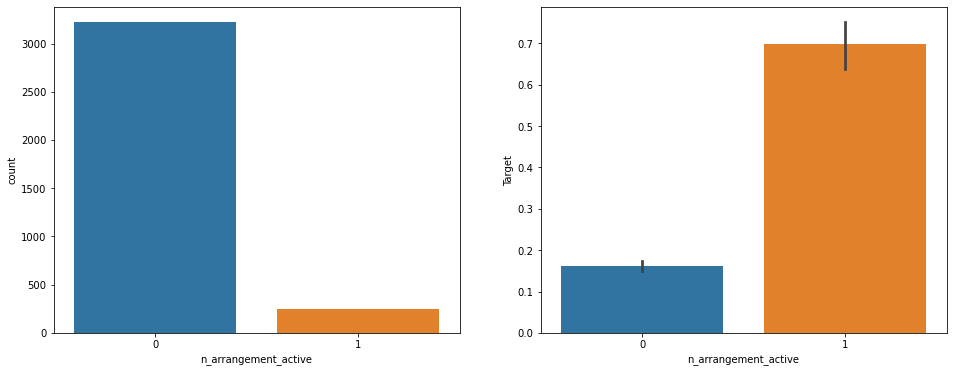

In [420]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='n_arrangement_active', data=data, ax=ax[0])
sns.barplot(x='n_arrangement_active',y='Target',data=data,ax=ax[1])

In [640]:
# impute age
def impute_age(age):
    if age==-9999:
        return np.nan
    else:
        return age
data['age']=data['age'].apply(impute_age)
data['age'].isnull().sum()

254

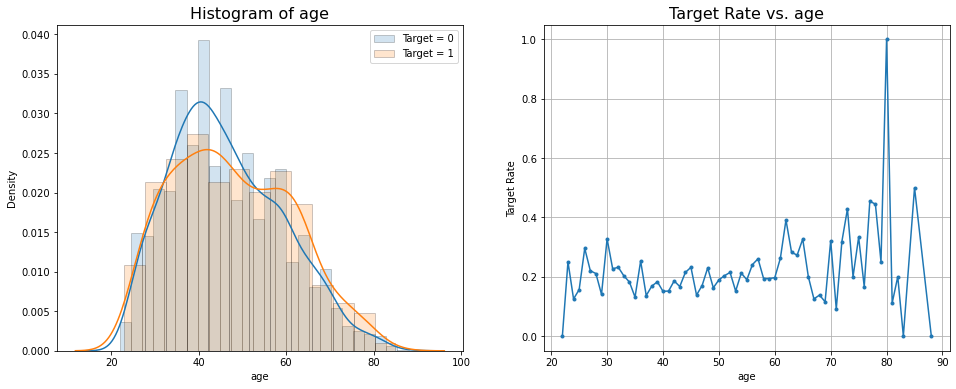

In [641]:
#visulization of 'age'
grouped=data[['age', 'Target']].groupby('age')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['Target'] == 0]['age'], 
             label='Target = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['Target'] == 1]['age'], 
             label='Target = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of age', fontsize=16)
ax[0].legend()
ax[1].plot(mean['age'], mean['Target'], '.-')
ax[1].set_title('Target Rate vs. age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Target Rate')
ax[1].grid(True)
plt.show()

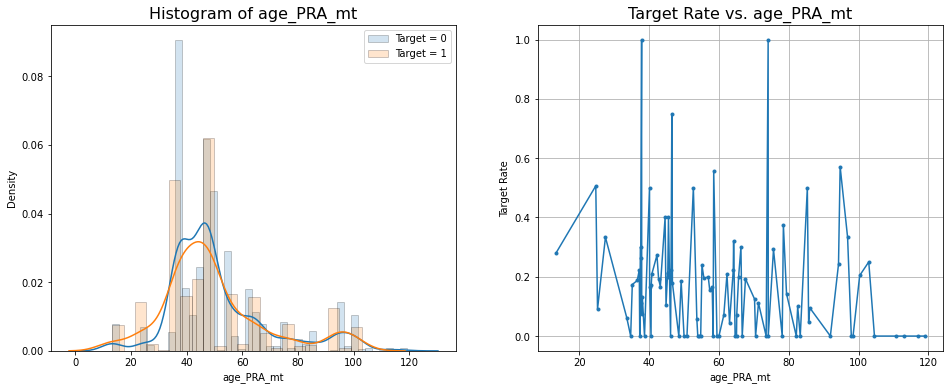

In [358]:
#visulization of 'age_PRA_mt'
grouped=data[['age_PRA_mt', 'Target']].groupby('age_PRA_mt')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['Target'] == 0]['age_PRA_mt'], 
             label='Target = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['Target'] == 1]['age_PRA_mt'], 
             label='Target = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of age_PRA_mt', fontsize=16)
ax[0].legend()
ax[1].plot(mean['age_PRA_mt'], mean['Target'], '.-')
ax[1].set_title('Target Rate vs. age_PRA_mt', fontsize=16)
ax[1].set_xlabel('age_PRA_mt')
ax[1].set_ylabel('Target Rate')
ax[1].grid(True)
plt.show()

Then we need to deal with date related to Legal. To make the problem simpler, we treat lawsuit- payment order - title obtained- excution as a whole process of the legal. So we will not treat them as different variables but create a varibles called 'legal' with 1 and 0 category to indicate whether legal process occured

In [642]:
# Feature engineering
# create variable of 'legal'
def legal(col):
    lawsuit=col[0]
    payment_order=col[1]
    title=col[2]
    excution=col[3]
    
    if pd.isnull(lawsuit) and pd.isnull(payment_order) and pd.isnull(title) and pd.isnull(excution):
        return 0
    else:
        return 1
data['legal']=data[['d_lawsuit_date','d_payment_order_date','d_title_day','d_execution_date']].apply(legal,axis=1)

<AxesSubplot:xlabel='legal', ylabel='Target'>

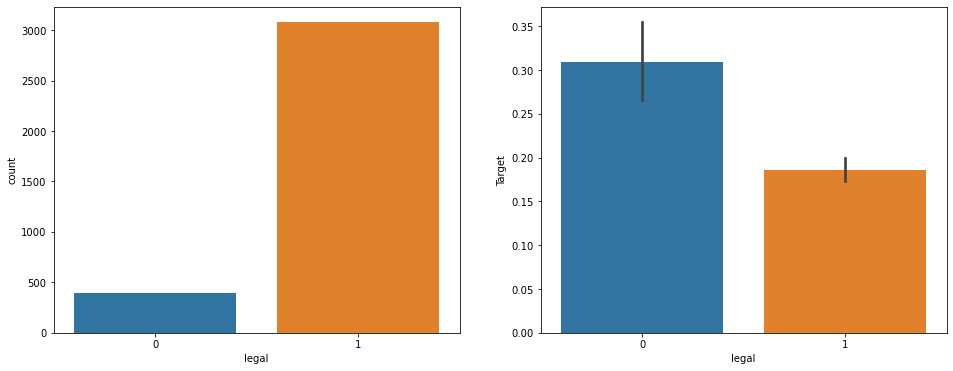

In [194]:
# Visualisation
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='legal', data=data, ax=ax[0])
sns.barplot(x='legal',y='Target',data=data,ax=ax[1])

In [643]:
# Feature Engineering
# check whether a new excution happen after last unsuccesfull exc
diff=data['d_execution_date']-data['d_unsuccesfull_exe_date']
diff=diff.apply(lambda x: 1 if x.days>0 else 0)
data['new_exc']=diff

#get the month since maturity
data.loc[data['c_accountid']==4243283,'d_maturity_date']=data['d_maturity_date'][0]
time_maturity=data['d_observation_date']-data['d_maturity_date']
time_maturity=time_maturity.apply(lambda x: x.days/30)
data['time_maturity']=time_maturity


<AxesSubplot:xlabel='new_exc', ylabel='Target'>

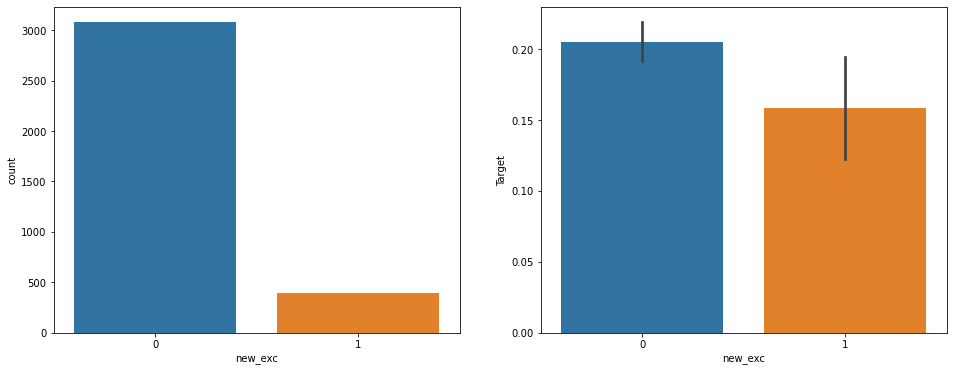

In [195]:
# visualisation
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='new_exc', data=data, ax=ax[0])
sns.barplot(x='new_exc',y='Target',data=data,ax=ax[1])

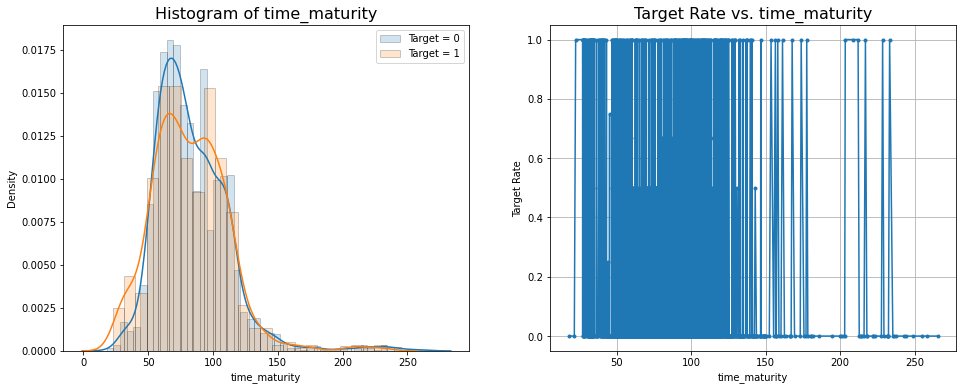

In [398]:
#visulization of 'time_maturity'
grouped=data[['time_maturity', 'Target']].groupby('time_maturity')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['Target'] == 0]['time_maturity'], 
             label='Target = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['Target'] == 1]['time_maturity'], 
             label='Target = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of time_maturity', fontsize=16)
ax[0].legend()
ax[1].plot(mean['time_maturity'], mean['Target'], '.-')
ax[1].set_title('Target Rate vs. time_maturity', fontsize=16)
ax[1].set_xlabel('time_maturity')
ax[1].set_ylabel('Target Rate')
ax[1].grid(True)
plt.show()

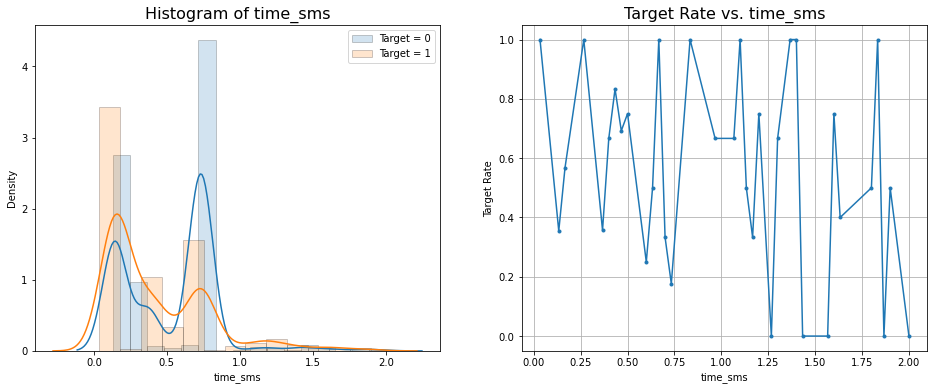

In [399]:
#visulization of 'time_sms'
grouped=data[['time_sms', 'Target']].groupby('time_sms')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['Target'] == 0]['time_sms'], 
             label='Target = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['Target'] == 1]['time_sms'], 
             label='Target = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of time_sms', fontsize=16)
ax[0].legend()
ax[1].plot(mean['time_sms'], mean['Target'], '.-')
ax[1].set_title('Target Rate vs. time_sms', fontsize=16)
ax[1].set_xlabel('time_sms')
ax[1].set_ylabel('Target Rate')
ax[1].grid(True)
plt.show()

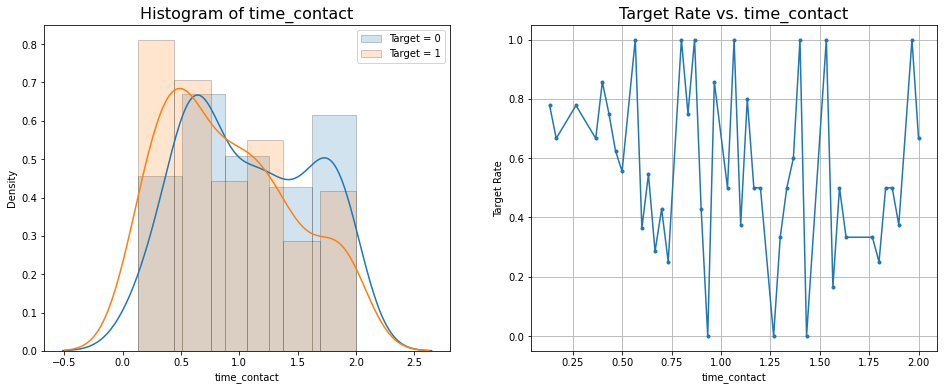

In [400]:
#visulization of 'time_contact'
grouped=data[['time_contact', 'Target']].groupby('time_contact')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['Target'] == 0]['time_contact'], 
             label='Target = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['Target'] == 1]['time_contact'], 
             label='Target = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of time_contact', fontsize=16)
ax[0].legend()
ax[1].plot(mean['time_contact'], mean['Target'], '.-')
ax[1].set_title('Target Rate vs. time_contact', fontsize=16)
ax[1].set_xlabel('time_contact')
ax[1].set_ylabel('Target Rate')
ax[1].grid(True)
plt.show()

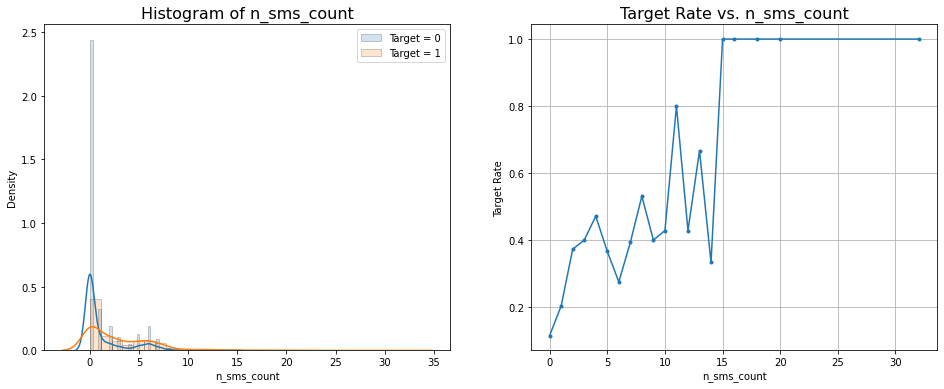

In [402]:
#visulization of 'n_sms_count'
grouped=data[['n_sms_count', 'Target']].groupby('n_sms_count')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['Target'] == 0]['n_sms_count'], 
             label='Target = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['Target'] == 1]['n_sms_count'], 
             label='Target = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of n_sms_count', fontsize=16)
ax[0].legend()
ax[1].plot(mean['n_sms_count'], mean['Target'], '.-')
ax[1].set_title('Target Rate vs. n_sms_count', fontsize=16)
ax[1].set_xlabel('n_sms_count')
ax[1].set_ylabel('Target Rate')
ax[1].grid(True)
plt.show()

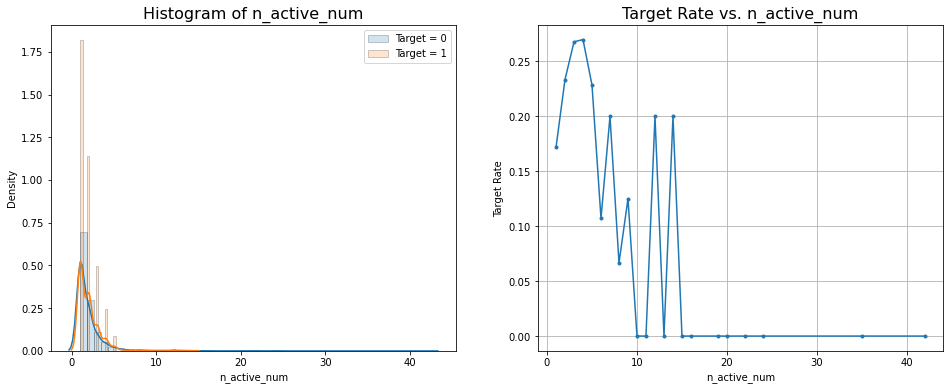

In [429]:
#visulization of 'n_active_num'
grouped=data[['n_active_num', 'Target']].groupby('n_active_num')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['Target'] == 0]['n_active_num'], 
             label='Target = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['Target'] == 1]['n_active_num'], 
             label='Target = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of n_active_num', fontsize=16)
ax[0].legend()
ax[1].plot(mean['n_active_num'], mean['Target'], '.-')
ax[1].set_title('Target Rate vs. n_active_num', fontsize=16)
ax[1].set_xlabel('n_active_num')
ax[1].set_ylabel('Target Rate')
ax[1].grid(True)
plt.show()

In [644]:
#Define Features and target to be used
columns=['n_account_balance','n_active_num','c_type_of_portfolio_rap','n_sms_count','n_arrangement_active','gender','age','age_PRA_mt','time_contact','time_sms','time_inbound','contact_works','sms_works','inbound_works','legal','new_exc','time_maturity','n_pay_30','n_pay_60',
         'n_pay_90','n_pay_180','n_pay_count_30','n_pay_count_60','n_pay_count_90','n_pay_count_180','vendor','sub_region','n_deceased','n_bancrupcy_failed_lawsuits_etc','Target_Amount','Target']
data=data[columns]
data.head()

,n_account_balance,n_active_num,c_type_of_portfolio_rap,n_sms_count,n_arrangement_active,gender,age,age_PRA_mt,time_contact,time_sms,...,n_pay_count_30,n_pay_count_60,n_pay_count_90,n_pay_count_180,vendor,sub_region,n_deceased,n_bancrupcy_failed_lawsuits_etc,Target_Amount,Target
0,4643.12,2,telecom,0,0,M,31.0,45.3,NaN,NaN,...,0,0,0,0,2,1,0,0,3500.0,1
1,4823.09,4,telecom,0,0,M,28.0,45.3,NaN,NaN,...,0,0,0,0,2,3,0,0,0.0,0
2,966.41,1,telecom,4,0,M,35.0,45.3,NaN,0.366667,...,0,0,0,0,2,2,0,0,0.0,0
3,496.58,1,telecom,6,0,M,31.0,45.3,NaN,0.366667,...,0,0,0,0,2,2,0,0,0.0,0
4,2609.66,1,telecom,0,0,M,30.0,45.3,NaN,NaN,...,0,0,0,0,2,3,0,0,0.0,0


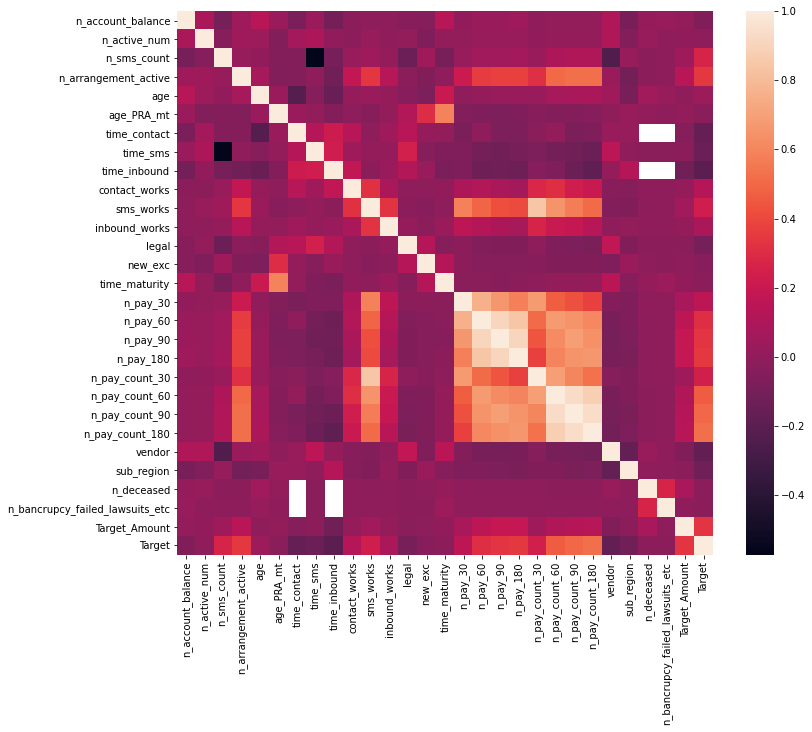

In [627]:
# features corelation
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(data.corr(), ax=ax)
plt.show()

very high correlation between time_contact, time_inbound, and n_deceased, n_bancrupcy_failed_lawsuits_etc, so we remove last 2 features

In [645]:
#Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 days 12 hours 20 mins
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,9 days
H2O_cluster_name:,H2O_from_python_xiaomengfu_8z4yk5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,772 Mb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [312]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3470 entries, 0 to 3469
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   n_account_balance                3470 non-null   object 
 1   n_active_num                     3470 non-null   int64  
 2   c_type_of_portfolio_rap          3470 non-null   object 
 3   n_sms_count                      3470 non-null   int64  
 4   n_deceased                       3470 non-null   int64  
 5   n_bancrupcy_failed_lawsuits_etc  3470 non-null   int64  
 6   n_arrangement_active             3470 non-null   int64  
 7   gender                           3470 non-null   object 
 8   age                              3216 non-null   float64
 9   age_PRA_mt                       3470 non-null   float64
 10  time_contact                     223 non-null    float64
 11  time_sms                         1326 non-null   float64
 12  time_inbound        

In [646]:
h2o_df = H2OFrame(data)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [481]:
h2o_df

n_account_balance,n_active_num,c_type_of_portfolio_rap,n_sms_count,n_arrangement_active,gender,age,age_PRA_mt,time_contact,time_sms,time_inbound,contact_works,sms_works,inbound_works,legal,new_exc,time_maturity,n_pay_30,n_pay_60,n_pay_90,n_pay_180,n_pay_count_30,n_pay_count_60,n_pay_count_90,n_pay_count_180,vendor,sub_region,n_deceased,n_bancrupcy_failed_lawsuits_etc,Target_Amount,Target
4643.12,2,telecom,0,0,M,31,45.3,nan,nan,nan,0,0,0,0,0,81.3333,0,0,0,0,0,0,0,0,2,1,0,0,3500,1
4823.09,4,telecom,0,0,M,28,45.3,nan,nan,nan,0,0,0,1,0,75.3,0,0,0,0,0,0,0,0,2,3,0,0,0,0
966.41,1,telecom,4,0,M,35,45.3,nan,0.366667,nan,0,0,0,0,0,83.4667,0,0,0,0,0,0,0,0,2,2,0,0,0,0
496.58,1,telecom,6,0,M,31,45.3,nan,0.366667,nan,0,0,0,1,0,73.4667,0,0,0,0,0,0,0,0,2,2,0,0,0,0
2609.66,1,telecom,0,0,M,30,45.3,nan,nan,nan,0,0,0,0,0,82.3333,0,0,0,0,0,0,0,0,2,3,0,0,0,0
1708.74,2,telecom,0,0,M,38,45.3,nan,nan,nan,0,0,0,1,0,79.3,0,0,0,0,0,0,0,0,2,2,0,0,0,0
384.6,1,telecom,6,0,M,54,45.3,nan,0.366667,nan,0,0,0,1,1,77,0,0,0,0,0,0,0,0,2,2,0,0,0,0
535.07,1,telecom,5,0,M,40,45.3,nan,0.366667,nan,0,0,0,1,0,78.3,0,0,0,0,0,0,0,0,2,3,0,0,350,1
358.12,1,telecom,0,0,K,45,45.3,nan,nan,nan,0,0,0,0,0,84.5,0,0,0,0,0,0,0,0,2,3,0,0,0,0
2116.28,1,telecom,0,0,M,36,45.3,nan,nan,nan,0,0,0,1,0,76.2667,0,0,0,0,0,0,0,0,2,3,0,0,0,0


In [647]:
for name in ['vendor', 'c_type_of_portfolio_rap', 'sub_region', 'gender', 'Target']:
    h2o_df[name] = h2o_df[name].asfactor()

h2o_df.summary()

,n_account_balance,n_active_num,c_type_of_portfolio_rap,n_sms_count,n_arrangement_active,gender,age,age_PRA_mt,time_contact,time_sms,time_inbound,contact_works,sms_works,inbound_works,legal,new_exc,time_maturity,n_pay_30,n_pay_60,n_pay_90,n_pay_180,n_pay_count_30,n_pay_count_60,n_pay_count_90,n_pay_count_180,vendor,sub_region,n_deceased,n_bancrupcy_failed_lawsuits_etc,Target_Amount,Target
type,real,int,enum,int,int,enum,int,real,enum,enum,enum,int,int,int,int,int,real,real,real,real,real,int,int,int,int,enum,enum,int,int,real,enum
mins,13.17,1.0,,0.0,0.0,,22.0,13.266666666666667,,,,0.0,0.0,0.0,0.0,0.0,17.766666666666666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0.0,0.0,0.0,
mean,14385.726939481303,1.9659942363112406,,1.515273775216138,0.0717579250720461,,46.65111940298519,50.820403458213235,,,,0.004610951008645533,0.0138328530259366,0.0020172910662824206,0.8870317002881845,0.11268011527377522,83.50208585247887,4.735904899135447,24.211847262247844,45.87264841498563,104.0915994236311,0.014121037463976945,0.07752161383285312,0.14178674351585013,0.31815561959654187,,,0.004034582132564841,0.0020172910662824206,160.87266570605217,
maxs,342964.73,42.0,,32.0,1.0,,88.0,119.0,,,,1.0,1.0,1.0,1.0,1.0,265.43333333333334,2000.0,4000.0,6000.0,12000.0,1.0,3.0,5.0,8.0,,,1.0,2.0,21000.0,
sigma,27643.229668612734,2.062443152068905,,2.617693223436366,0.2581238586278418,,12.921133616111119,18.433811156967646,,,,0.06775701585813756,0.11681368757927171,0.04487540472708225,0.31659966715053484,0.3162469428070561,28.992426649492277,58.58080751034446,151.85215186913595,265.20627670544854,569.2914798271216,0.11800697826675248,0.32665159467912874,0.5401816106077671,1.1508774643777313,,,0.06339923206284578,0.05089535316629775,973.097862079264,
zeros,0,0,,2144,3221,,0,0,,,,3454,3422,3463,392,3079,0,3421,3259,3208,3157,3421,3259,3208,3157,,,3456,3464,2776,
missing,0,0,0,0,0,0,254,0,0,0,0,0,0,0,0,0,162,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,4643.12,2.0,telecom,0.0,0.0,M,31.0,45.3,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,81.33333333333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,0.0,0.0,3500.0,1
1,4823.09,4.0,telecom,0.0,0.0,M,28.0,45.3,nan,nan,nan,0.0,0.0,0.0,1.0,0.0,75.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,3,0.0,0.0,0.0,0
2,966.41,1.0,telecom,4.0,0.0,M,35.0,45.3,nan,0.36666666666666664,nan,0.0,0.0,0.0,0.0,0.0,83.46666666666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,0.0,0.0,0.0,0


In [648]:
# Split into 70% training and 30% test dataset
strat_split = h2o_df['Target'].stratified_split(test_frac=0.3, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

# Define features and target
feature = ['n_account_balance','n_active_num','c_type_of_portfolio_rap','n_sms_count','n_arrangement_active','gender','age','age_PRA_mt','time_contact','time_inbound','contact_works','sms_works','inbound_works','legal','new_exc','time_maturity','n_pay_30','n_pay_60',
         'n_pay_90','n_pay_180','n_pay_count_30','n_pay_count_60','n_pay_count_90','n_pay_count_180','vendor','sub_region']
target = 'Target'

In [649]:
# Build random forest model 
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, mtries=-1, stopping_rounds=5, 
                                 stopping_metric='auc', score_each_iteration=True, seed=42)
model.train(x=feature, y=target, training_frame=train, validation_frame=test)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1657920152654_450


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,20.0,20.0,93960.0,20.0,20.0,20.0,242.0,406.0,359.5




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.03877272947290995
RMSE: 0.19690792130564466
LogLoss: 0.23071897462471522
Mean Per-Class Error: 0.025737117137735056
AUC: 0.9929727795366027
AUCPR: 0.9883360978860408
Gini: 0.9859455590732054

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3371743369241894: 


,,0,1,Error,Rate
0,0,1878.0,64.0,0.033,(64.0/1942.0)
1,1,36.0,1908.0,0.0185,(36.0/1944.0)
2,Total,1914.0,1972.0,0.0257,(100.0/3886.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.337174,0.974464,220.0
1,max f2,0.246381,0.984949,250.0
2,max f0point5,0.385666,0.971245,204.0
3,max accuracy,0.337174,0.974267,220.0
4,max precision,0.851852,0.991241,34.0
5,max recall,0.174747,1.000000,272.0
6,max specificity,1.000000,0.993821,0.0
7,max absolute_mcc,0.337174,0.948631,220.0
8,max min_per_class_accuracy,0.381162,0.969619,207.0
9,max mean_per_class_accuracy,0.337174,0.974263,220.0



Gains/Lift Table: Avg response rate: 50.01 %, avg score: 47.19 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.332133,1.000000,1.980900,1.980900,0.990705,1.000000,0.990705,1.000000,0.657922,0.657922,98.090014,98.090014,0.651746
1,2,0.400051,0.676122,1.969190,1.978912,0.984848,0.792963,0.989711,0.964850,0.133745,0.791667,96.919036,97.891211,0.783432
2,3,0.500129,0.380621,1.778463,1.938802,0.889460,0.553145,0.969650,0.882467,0.177984,0.969650,77.846277,93.880162,0.939285
3,4,0.599949,0.105244,0.304045,1.666810,0.152062,0.201693,0.833619,0.769199,0.030350,1.000000,-69.595451,66.680961,0.800309
4,5,0.703113,0.045409,0.000000,1.422247,0.000000,0.068576,0.711306,0.666400,0.000000,1.000000,-100.000000,42.224662,0.593927
5,6,0.803962,0.012040,0.000000,1.243840,0.000000,0.029310,0.622080,0.586484,0.000000,1.000000,-100.000000,24.384000,0.392177
6,7,1.000000,0.000000,0.000000,1.000000,0.000000,0.001996,0.500129,0.471902,0.000000,1.000000,-100.000000,0.000000,0.000000




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.11104888732791433
RMSE: 0.33323998458755566
LogLoss: 0.42304535876094934
Mean Per-Class Error: 0.25836296056884295
AUC: 0.8223924185058639
AUCPR: 0.6660634874864282
Gini: 0.6447848370117277

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16417910439462485: 


,,0,1,Error,Rate
0,0,763.0,70.0,0.084,(70.0/833.0)
1,1,90.0,118.0,0.4327,(90.0/208.0)
2,Total,853.0,188.0,0.1537,(160.0/1041.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.164179,0.595960,75.0
1,max f2,0.062317,0.654762,214.0
2,max f0point5,0.342122,0.696108,26.0
3,max accuracy,0.342122,0.868396,26.0
4,max precision,0.936508,0.976190,1.0
5,max recall,0.001195,1.000000,398.0
6,max specificity,1.000000,0.998800,0.0
7,max absolute_mcc,0.342122,0.536633,26.0
8,max min_per_class_accuracy,0.074253,0.726291,189.0
9,max mean_per_class_accuracy,0.107438,0.750707,145.0



Gains/Lift Table: Avg response rate: 19.98 %, avg score: 13.44 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.039385,1.000000,4.882739,4.882739,0.975610,1.000000,0.975610,1.000000,0.192308,0.192308,388.273921,388.273921,0.191107
1,2,0.040346,0.870255,5.004808,4.885646,1.000000,0.936508,0.976190,0.998488,0.004808,0.197115,400.480769,388.564560,0.195915
2,3,0.058598,0.826087,4.741397,4.840716,0.947368,0.826087,0.967213,0.944790,0.086538,0.283654,374.139676,384.071564,0.281253
3,4,0.103746,0.384219,2.981588,4.031651,0.595745,0.534601,0.805556,0.766282,0.134615,0.418269,198.158756,303.165064,0.393059
4,5,0.151777,0.209076,1.701635,3.294304,0.340000,0.278496,0.658228,0.611919,0.081731,0.500000,70.163462,229.430380,0.435174
5,6,0.205572,0.142857,1.608688,2.853208,0.321429,0.167376,0.570093,0.495590,0.086538,0.586538,60.868819,185.320812,0.476094
6,7,0.301633,0.096774,1.051010,2.279260,0.210000,0.117530,0.455414,0.375189,0.100962,0.687500,5.100962,127.925955,0.482218
7,8,0.406340,0.063708,0.918313,1.928567,0.183486,0.077007,0.385343,0.298352,0.096154,0.783654,-8.168666,92.856656,0.471529
8,9,0.500480,0.044455,0.510695,1.661865,0.102041,0.053665,0.332054,0.252327,0.048077,0.831731,-48.930534,66.186513,0.413964
9,10,0.601345,0.030430,0.524313,1.471062,0.104762,0.036564,0.293930,0.216137,0.052885,0.884615,-47.568681,47.106169,0.354003




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-07-18 10:43:31,0.039 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-07-18 10:43:31,0.209 sec,1.0,0.328992,3.034964,0.904638,0.860280,1.734090,0.110490,0.457965,6.811814,0.696172,0.379662,2.343160,0.222863
2,,2022-07-18 10:43:31,0.309 sec,2.0,0.317417,2.628491,0.914566,0.871743,1.758946,0.105832,0.375153,3.278283,0.729404,0.499817,3.707265,0.150817
3,,2022-07-18 10:43:31,0.422 sec,3.0,0.302394,2.331901,0.924138,0.880430,1.772210,0.095682,0.350821,2.196470,0.760002,0.576669,4.408997,0.195005
4,,2022-07-18 10:43:31,0.546 sec,4.0,0.282215,1.850744,0.937929,0.903164,1.819184,0.083257,0.346895,1.828283,0.774569,0.595251,4.491494,0.212296
5,,2022-07-18 10:43:31,0.634 sec,5.0,0.293802,1.491347,0.942385,0.912765,1.844596,0.086448,0.341437,1.059634,0.775957,0.616399,4.642140,0.158501
6,,2022-07-18 10:43:31,0.742 sec,6.0,0.280850,1.173121,0.952850,0.927910,1.873626,0.080858,0.339239,0.905847,0.789422,0.627909,4.687042,0.181556
7,,2022-07-18 10:43:31,0.820 sec,7.0,0.266767,0.962075,0.960985,0.939219,1.894113,0.073735,0.337050,0.838905,0.802443,0.638671,4.671154,0.149856
8,,2022-07-18 10:43:31,0.861 sec,8.0,0.254895,0.832465,0.967568,0.945643,1.901600,0.065908,0.336612,0.809934,0.801023,0.645115,4.745938,0.163305
9,,2022-07-18 10:43:31,0.889 sec,9.0,0.243768,0.678888,0.974040,0.956130,1.921204,0.057188,0.337301,0.780596,0.803003,0.641373,4.741397,0.155620



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,n_pay_180,1599.819092,1.000000,0.121893
1,age,1517.238525,0.948381,0.115601
2,time_maturity,1227.588989,0.767330,0.093532
3,n_account_balance,1001.315552,0.625893,0.076292
4,n_sms_count,910.774048,0.569298,0.069393
5,time_contact,869.703186,0.543626,0.066264
6,n_pay_count_180,865.769165,0.541167,0.065964
7,n_pay_90,713.421509,0.445939,0.054357
8,age_PRA_mt,631.103760,0.394484,0.048085
9,n_pay_count_60,595.479675,0.372217,0.045371



See the whole table with table.as_data_frame()


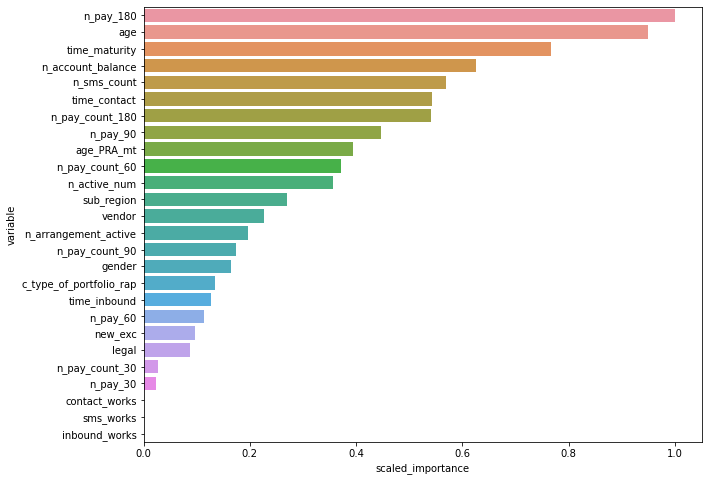

In [634]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [650]:
# Make predictions 
train_true = train.as_data_frame()['Target'].values
test_true = test.as_data_frame()['Target'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [651]:
model.predict(train)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.101617,0.898383
0,0.972973,0.027027
0,0.977118,0.0228819
0,0.957746,0.0422535
0,0.941176,0.0588235
0,0.974144,0.0258564
0,0.983871,0.016129
1,0.467523,0.532477
0,0.993346,0.00665409
0,0.996477,0.00352279


In [630]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.164).astype(int)))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       833
           1       0.63      0.57      0.60       208

    accuracy                           0.85      1041
   macro avg       0.76      0.74      0.75      1041
weighted avg       0.84      0.85      0.84      1041



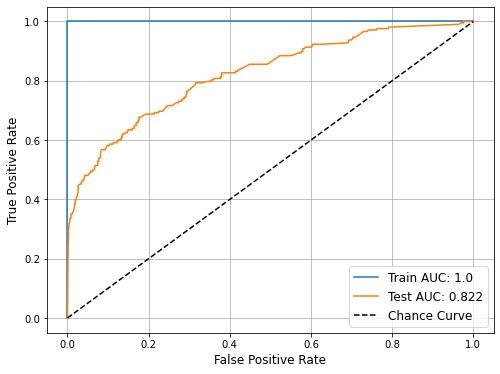

In [582]:
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

## Regression model for target amount

In [491]:
data2=data[data['Target']==1]

In [492]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 694 entries, 0 to 3459
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   n_account_balance                694 non-null    float64
 1   n_active_num                     694 non-null    int64  
 2   c_type_of_portfolio_rap          694 non-null    object 
 3   n_sms_count                      694 non-null    int64  
 4   n_arrangement_active             694 non-null    int64  
 5   gender                           694 non-null    object 
 6   age                              657 non-null    float64
 7   age_PRA_mt                       694 non-null    float64
 8   time_contact                     123 non-null    float64
 9   time_sms                         447 non-null    float64
 10  time_inbound                     45 non-null     float64
 11  contact_works                    694 non-null    int64  
 12  sms_works            

<AxesSubplot:xlabel='Target_Amount', ylabel='Density'>

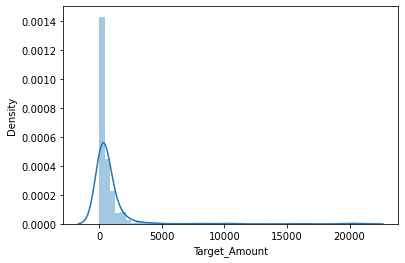

In [542]:
sns.distplot(data2['Target_Amount'])

<AxesSubplot:xlabel='Target_Amount', ylabel='Density'>

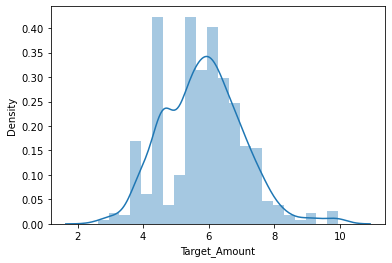

In [593]:
#log transformation
sns.distplot(data2['Target_Amount'].apply(lambda x:np.log(x)))


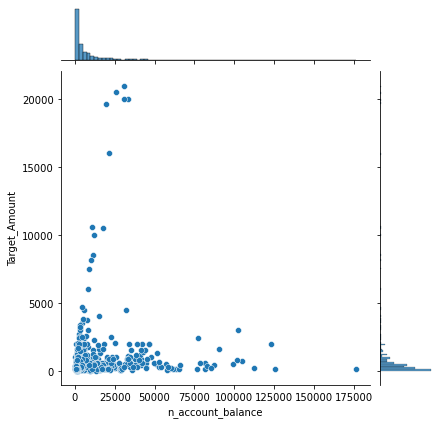

In [538]:
sns.jointplot(x='n_account_balance',y='Target_Amount',data=data2,kind='scatter')

<AxesSubplot:xlabel='n_pay_count_180', ylabel='Target_Amount'>

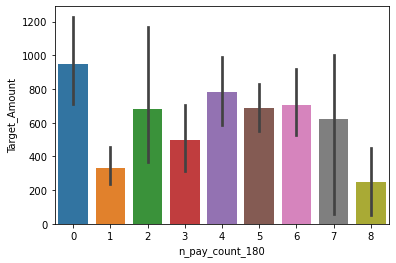

In [598]:
sns.barplot(x='n_pay_count_180',y='Target_Amount',data=data2)

<AxesSubplot:xlabel='n_arrangement_active', ylabel='Target_Amount'>

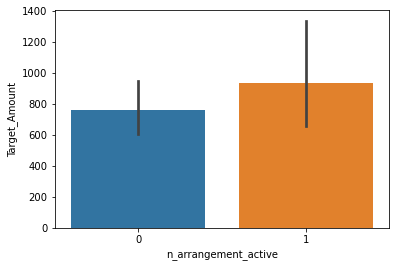

In [597]:
sns.barplot(x='n_arrangement_active',y='Target_Amount',data=data2)

<AxesSubplot:xlabel='n_active_num', ylabel='Target_Amount'>

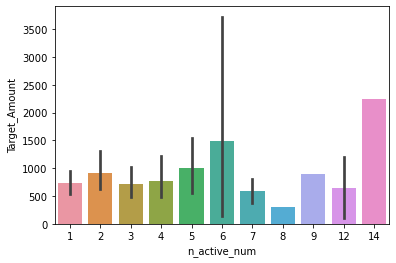

In [599]:
sns.barplot(x='n_active_num',y='Target_Amount',data=data2)

<AxesSubplot:xlabel='vendor', ylabel='Target_Amount'>

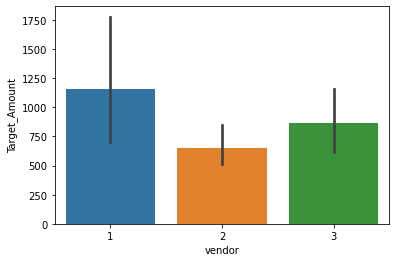

In [600]:
sns.barplot(x='vendor',y='Target_Amount',data=data2)

<AxesSubplot:xlabel='sub_region', ylabel='Target_Amount'>

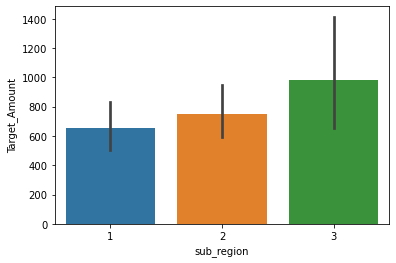

In [601]:
sns.barplot(x='sub_region',y='Target_Amount',data=data2)

<AxesSubplot:xlabel='gender', ylabel='Target_Amount'>

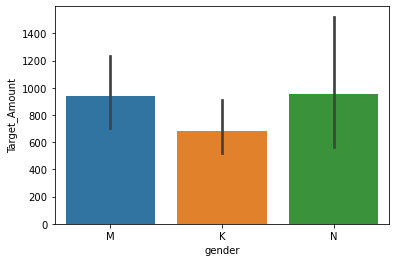

In [612]:
sns.barplot(x='gender',y='Target_Amount',data=data2)

In [617]:
# train linear regression model
X=data2[['n_account_balance','n_active_num','n_sms_count','n_arrangement_active','age','age_PRA_mt','time_maturity','vendor','sub_region','n_pay_30','n_pay_60',
         'n_pay_90','n_pay_180','n_pay_count_30','n_pay_count_60','n_pay_count_90','n_pay_count_180']]
y=data2['Target_Amount'].apply(lambda x:np.log(x))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train)) # use X_train to fit, then transform
imputed_X_test = pd.DataFrame(my_imputer.transform(X_test)) # transform (using the fitted one from X_train

imputed_X_train.columns = X_train.columns
imputed_X_test.columns = X_test.columns

lm = LinearRegression()
lm.fit(imputed_X_train,y_train)




LinearRegression()

In [604]:
## check coefficients
print(lm.intercept_)
print(lm.coef_)


5.634778889531948
[ 2.45858350e-06  8.63404135e-02 -9.69211034e-03  3.37853148e-01
 -1.39083306e-03  3.18386574e-03  5.85549343e-04 -5.74547180e-02
 -4.08474009e-02 -1.11472143e-03  2.99038919e-04  1.48332468e-04
  3.67048516e-04  1.16654525e-01 -5.65812623e-02  8.38886639e-02
 -1.58401935e-01]


In [625]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df
coeff_df.sort_values(by='Coefficient', ascending=False)

,Coefficient
n_arrangement_active,0.337853
n_pay_count_30,0.116655
n_active_num,0.086340
n_pay_count_90,0.083889
age_PRA_mt,0.003184
time_maturity,0.000586
n_pay_180,0.000367
n_pay_60,0.000299
n_pay_90,0.000148
n_account_balance,0.000002


In [606]:
importance = lm.coef_
importance
plt.bar([x for x in range(len(importance))],importance)

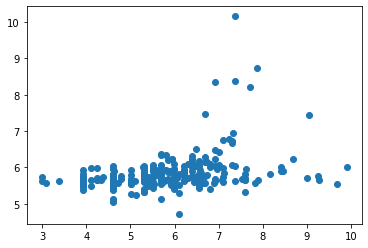

In [609]:
predictions = lm.predict(imputed_X_test)
plt.scatter(y_test,predictions)

Text(0.5, 1.0, 'Residual Histogram')

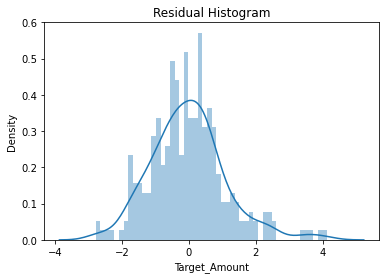

In [610]:
sns.distplot((y_test-predictions),bins=50)
plt.title('Residual Histogram')

In [611]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2:', r2_score(y_test, predictions))

MAE: 0.8452574518848577
MSE: 1.2489137113234854
RMSE: 1.1175480800947606
R2: 0.1279945651261032


## Another Approach: only 1 model with 3 classification 

In [ ]:
data['Target'].mean()
def target_set(col):
    target_amount=col[0]
    target=col[1]
    if target_amount>=500:
        return 2
    if target_amount==0:
        return 0
    else:
        return 1
data['Target']=data[['Target_Amount','Target']].apply(target_set,axis=1)